# Analysis of data
In this notebook we'll look at the downloaded data and explore what it tells us

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas
from shapely.geometry import Point, LineString

In [2]:
geo_data_dir = '../data/geo_data'
weather_data_dir = '../data/weather_data'
taxi_zones_file = '../data/taxi_zones'
green_tripdata_file = '../data/taxi_data/consolidated_green_tripdata.csv'
yellow_tripdata_file = '../data/taxi_data/consolidated_yellow_tripdata.csv'

* Load the shape file of NYC (this contains the shape files for each location below) and display it

In [3]:
def get_taxi_zones(taxi_zones_file):
    taxi_zones = geopandas.read_file(taxi_zones_file).set_index('OBJECTID')
    zone_ids = taxi_zones.index.tolist()
    taxi_zones['centroids'] = taxi_zones.geometry.centroid
    return taxi_zones, zone_ids

,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroids
OBJECTID,,,,,,,
1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",POINT (935996.8210162065 191376.749530832)
2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",POINT (1031085.718603285 164018.7544032017)
3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",POINT (1026452.616873473 254265.4786585689)
4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",POINT (990633.9806410479 202959.7823911368)
5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",POINT (931871.3700680139 140681.3513759734)
6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.7466657609 158679.854687795, ...",POINT (964319.735448061 157998.9356119239)
7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.217962816 218919.6406951398,...",POINT (1006496.679158681 216719.2181686789)
8,0.027591,0.000027,Astoria Park,8,Queens,"POLYGON ((1005482.276373357 221686.4661663175,...",POINT (1005551.57117787 222936.0875515854)
9,0.099784,0.000338,Auburndale,9,Queens,"POLYGON ((1043803.993348822 216615.9250395149,...",POINT (1043002.677424325 212969.8490136597)


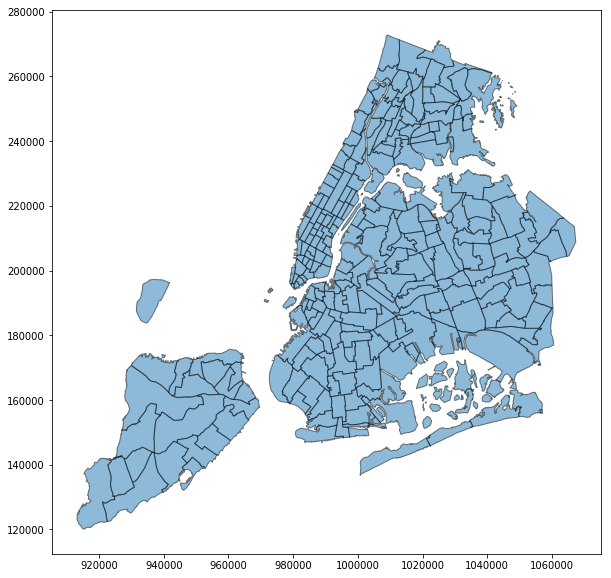

In [33]:
taxi_zones, zone_ids = get_taxi_zones(taxi_zones_file)
taxi_zones.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
taxi_zones.head(10)

### Load the taxi data

Load and cleanse the trip data

In [9]:
def load_tripdata(tripdata_file, zone_ids, delimiter=',', save=True):
    tripdata = pd.read_csv(tripdata_file, delimiter=delimiter)
    print('Loaded trip data from {}'.format(tripdata_file))
    print('Trip data contains {} rows'.format(len(tripdata)))
    tripdata = tripdata[(tripdata != 0).all(1)].dropna()
    tripdata = tripdata[(tripdata['PULocationID'].isin(zone_ids)) & 
                                (tripdata['DOLocationID'].isin(zone_ids))]
    print('Cleansed trip data contains {} rows'.format(len(tripdata)))
    if save:
        directory = os.path.dirname(tripdata_file)
        file = os.path.basename(tripdata_file)
        cleansed_file = os.path.join(directory, 'cleansed_{}'.format(file))
        print('Saving cleansed data to {}'.format(cleansed_file))
        tripdata.to_csv(cleansed_file, sep=delimiter)
        print('Done')
    return tripdata       

* Start with green taxi cab data as this is smaller

In [10]:
tripdata = load_tripdata(green_tripdata_file, zone_ids)
tripdata.head(10)

Loaded trip data from ../data/taxi_data/consolidated_green_tripdata.csv
Trip data contains 10108112 rows
Cleansed trip data contains 9946538 rows
Saving cleansed data to ../data/taxi_data/cleansed_consolidated_green_tripdata.csv
Done


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,total_amount
1,2,2017-07-01 00:56:23,2017-07-01 00:59:30,14,14,1,0.81,5.80
2,2,2017-07-01 00:15:25,2017-07-01 00:34:24,112,61,1,4.97,23.16
3,2,2017-07-01 00:55:06,2017-07-01 00:59:08,92,92,1,0.83,6.80
4,2,2017-07-01 00:34:05,2017-07-01 00:50:44,75,79,1,4.99,19.30
5,2,2017-07-01 00:09:19,2017-07-01 00:16:58,61,188,1,1.72,9.30
6,2,2017-07-01 00:24:20,2017-07-01 00:30:54,188,89,1,1.88,8.80
7,2,2017-07-01 00:41:22,2017-07-01 01:13:02,89,71,1,1.74,21.30
8,2,2017-07-01 00:20:02,2017-07-01 00:39:31,255,129,1,5.85,26.16
9,2,2017-07-01 00:46:38,2017-07-01 01:12:26,255,181,2,6.38,29.75
10,2,2017-07-01 00:07:32,2017-07-01 00:10:34,49,49,1,0.84,6.96


### Restart here

TODO - Start by loading the CSV

In [56]:
# green_tripdata = pd.read_csv('../data/taxi_data/cleansed_consolidated_green_tripdata.csv', delimiter=',')

'../data/taxi_data'

* Count of each pickup (PU) and drop-off (DO) location ID

In [11]:
def count_by_location_ids(tripdata):
    count_by_PU = tripdata.groupby('PULocationID')['PULocationID'].count()
    count_by_DO = tripdata.groupby('DOLocationID')['DOLocationID'].count()
    return count_by_PU, count_by_DO

In [14]:
taxi_zones['Count_by_PULocationID'], taxi_zones['Count_by_DOLocationID'] = count_by_location_ids(tripdata)
taxi_zones.head(10)

,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroids,Count_by_PULocationID,Count_by_DOLocationID
OBJECTID,,,,,,,,,
1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",POINT (935996.8210162065 191376.749530832),39.0,3426.0
2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",POINT (1031085.718603285 164018.7544032017),6.0,34.0
3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",POINT (1026452.616873473 254265.4786585689),4504.0,6033.0
4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",POINT (990633.9806410479 202959.7823911368),9.0,12185.0
5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",POINT (931871.3700680139 140681.3513759734),7.0,57.0
6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.7466657609 158679.854687795, ...",POINT (964319.735448061 157998.9356119239),60.0,154.0
7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.217962816 218919.6406951398,...",POINT (1006496.679158681 216719.2181686789),496700.0,312615.0
8,0.027591,0.000027,Astoria Park,8,Queens,"POLYGON ((1005482.276373357 221686.4661663175,...",POINT (1005551.57117787 222936.0875515854),254.0,1669.0
9,0.099784,0.000338,Auburndale,9,Queens,"POLYGON ((1043803.993348822 216615.9250395149,...",POINT (1043002.677424325 212969.8490136597),1777.0,4544.0


* This CRS will transform the map into lat/long coordinates

In [31]:
#taxi_zones_crs = taxi_zones.crs
#print(taxi_zones_crs)
# taxi_zones = taxi_zones.to_crs({'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True})

{'proj': 'lcc', 'lat_1': 40.66666666666666, 'lat_2': 41.03333333333333, 'lat_0': 40.16666666666666, 'lon_0': -74, 'x_0': 300000, 'y_0': 0, 'datum': 'NAD83', 'units': 'us-ft', 'no_defs': True}


### Plot volumes of pickups by zone on the map

In [15]:
def plot_volumes_by_location(taxi_zones, column, title, figsize=(10,10), cmap='Blues', scheme='quantiles'):
    fig, ax = plt.subplots(1, figsize=figsize)
    taxi_zones.plot(column=column, cmap=cmap, scheme=scheme, linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight' : 3})

/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/anaconda3/lib/python3.7/site-packa

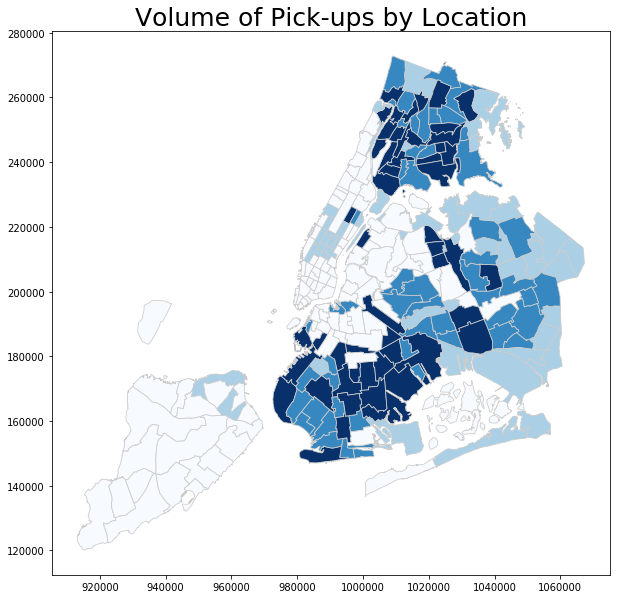

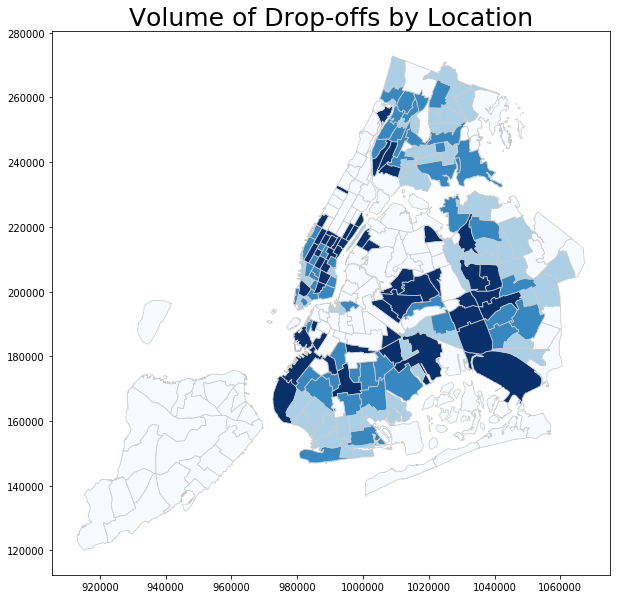

In [16]:
plot_volumes_by_location(taxi_zones, 'Count_by_PULocationID', 'Volume of Pick-ups by Location')
plot_volumes_by_location(taxi_zones, 'Count_by_DOLocationID', 'Volume of Drop-offs by Location')

* Now calculate the number of trips by unique pickup/drop-off combination

In [17]:
def calc_unique_trips_by_locations(tripdata):
    counts_by_trip = tripdata.groupby(['PULocationID', 'DOLocationID'])[['PULocationID', 'DOLocationID']].size().reset_index()
    counts_by_trip.rename(columns={0: 'count'}, inplace=True)
    return counts_by_trip

In [18]:
counts_by_trip = calc_unique_trips_by_locations(tripdata)
counts_by_trip.head(10)

,PULocationID,DOLocationID,count
0,1,1,33
1,1,23,1
2,1,66,2
3,1,132,1
4,1,166,1
5,1,243,1
6,2,124,2
7,2,196,1
8,2,197,1
9,2,216,1


* Determine linestrings for each unique trip

In [40]:
def get_trip_linestrings(taxi_zones, counts_by_trip):
    journeys = []
    for i, journey in counts_by_trip.iterrows():
        #print(journey[['PULocationID', 'DOLocationID']].values)
        start_centroid = taxi_zones.loc[journey['PULocationID'], 'centroids']
        end_centroid = taxi_zones.loc[journey['DOLocationID'], 'centroids']
        journeys.append(LineString([start_centroid, end_centroid]))
    return journeys

In [50]:
counts_by_trip['journey'] = get_trip_linestrings(taxi_zones, counts_by_trip)
counts_by_trip.head(10)

,PULocationID,DOLocationID,count,journey
0,1,1,33,LINESTRING (935996.8210162065 191376.749530832...
1,1,23,1,LINESTRING (935996.8210162065 191376.749530832...
2,1,66,2,LINESTRING (935996.8210162065 191376.749530832...
3,1,132,1,LINESTRING (935996.8210162065 191376.749530832...
4,1,166,1,LINESTRING (935996.8210162065 191376.749530832...
5,1,243,1,LINESTRING (935996.8210162065 191376.749530832...
6,2,124,2,LINESTRING (1031085.718603285 164018.754403201...
7,2,196,1,LINESTRING (1031085.718603285 164018.754403201...
8,2,197,1,LINESTRING (1031085.718603285 164018.754403201...
9,2,216,1,LINESTRING (1031085.718603285 164018.754403201...


In [51]:
# journeys = geopandas.GeoDataFrame(counts_by_trip, geometry='journey')
# journeys.plot(figsize=(15, 15), color='red')

* Now plot on the map of NYC

In [52]:
def plot_trips(taxi_zones, counts_by_trip, column, title, figsize=(10,10), cmap='Blues', scheme='quantiles'):
    ax = taxi_zones.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
    journeys = geopandas.GeoDataFrame(counts_by_trip, geometry='journey')
    # journeys.crs = taxi_zones.crs  #{'init': 'epsg:4326'}
    # journeys.to_crs(taxi_zones.crs)
    journeys.plot(ax=ax, color='red')
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight' : 3})

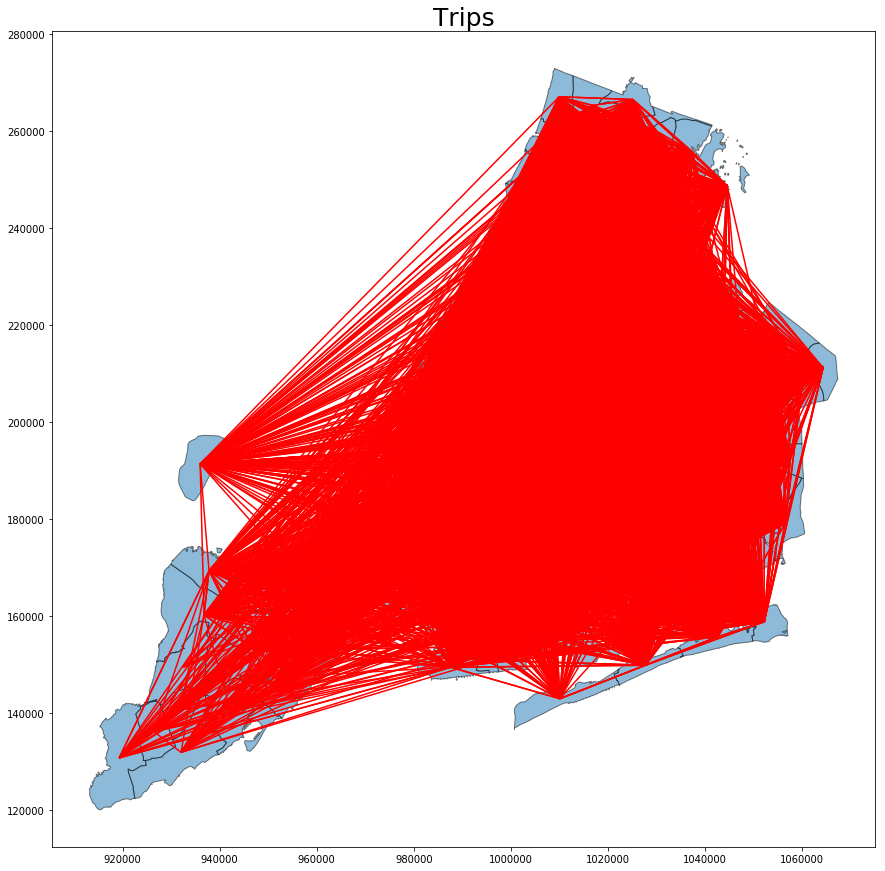

In [53]:
plot_trips(taxi_zones, counts_by_trip, 'journey', 'Trips')